# Imports

In [1]:
import os
import sys
from oggm import utils
import time
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import json
from shapely.geometry import Point

In [2]:
# go up until we are in the project base directory
base_dir = os.getcwd()
while base_dir.split('/')[-1] != 'provide':
    base_dir = os.path.normpath(os.path.join(base_dir, '..'))

# add paths for tools and data
things_to_add = ['general_tools', 'aggregation_tools']
for thing in things_to_add:
    sys.path.append(os.path.join(base_dir, thing))

# import stuff we need
from general_tools import check_if_notebook
from aggregation_preprocessing import (get_global_grid, get_squared_grid_for_shape,
    _lonlat_grid_from_dataset, assign_rgi_ids_to_grid_points, plot_local_grid_with_glaciers,
    get_result_batches_of_glaciers, merge_result_structures, serialize_dataset,
    open_grid_from_dict)

In [3]:
# Use this to conditionally execute tests/debugging
if check_if_notebook():
    is_notebook = True
else:
    is_notebook = False

# Define directories

In [ ]:
resolution_dir = 'resolution_2_5_deg'

In [4]:
preprocess_country_dict_outpath = os.path.join(base_dir, 'countries', resolution_dir)
utils.mkdir(preprocess_country_dict_outpath);

In [5]:
grid_plots_outpath = os.path.join(base_dir, 'countries', resolution_dir, 'grid_plots')
utils.mkdir(grid_plots_outpath);

In [6]:
aggregated_data_outpath = os.path.join(base_dir, 'countries', resolution_dir, 'aggregated_data')
utils.mkdir(aggregated_data_outpath);

In [7]:
countries_data_dir = os.path.join(base_dir, 'countries', 'data')
general_data_dir = os.path.join(base_dir, 'general_data_for_aggregation')

# Open data

In [8]:
countries_file = 'ne_10m_admin_0_countries_deu_CA.shp'
gdf_countries = gpd.read_file(os.path.join(countries_data_dir, countries_file))
name_col_countries = 'ADM0_A3_DE'

In [9]:
# open dict_country_to_rgi_ids from data
with open(os.path.join(countries_data_dir,
                       "dict_country_to_rgi_ids.json"), "r") as f:
    dict_country_to_rgi_ids = json.load(f)

In [10]:
# this list is already cleaned from connectivity 2, RGI19 and only common running glaciers
fp_rgi_result_batch = "rgi_ids_to_result_batch.json"
with open(os.path.join(general_data_dir, fp_rgi_result_batch), 'r') as f:
    dict_rgis_to_batch = json.load(f)

In [11]:
df_rgi = pd.read_csv(os.path.join(general_data_dir, 'rgi_position_terminus_backdrop_centroid.csv'),
                     index_col=0)
# only keep rgi_ids which are assigned to a result file
# (excluding connectivity 2 and RGI19, in future also only commonly running glaciers)
df_rgi = df_rgi.loc[list(dict_rgis_to_batch.keys())]
df_rgi['geometry'] = df_rgi.apply(lambda row: Point(row['position_lon'], row['position_lat']), axis=1)
gdf_rgi_ids = gpd.GeoDataFrame(df_rgi, geometry='geometry', crs='EPSG:4326')

# Settings for this run

In [12]:
resolution = 2.5
save_local_grid_plots = True

# Workflow for testing in notebook

## define test country

In [13]:
if is_notebook:
    test_country_index = gdf_countries[gdf_countries['NAME'] == 'Austria'].index[0]
    test_country = gdf_countries.iloc[test_country_index: test_country_index + 1]

## get raw grid for country

/home/users/pschmitt/mambaforge/envs/oggm_env/lib/python3.11/site-packages/salem/gis.py:1245: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  out['geometry'] = geoms
/home/users/pschmitt/mambaforge/envs/oggm_env/lib/python3.11/site-packages/salem/gis.py:1245: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `se

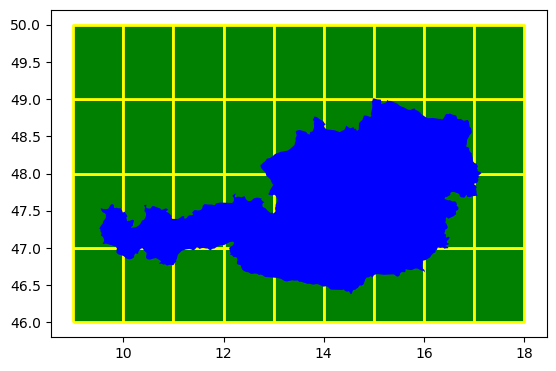

In [14]:
if is_notebook:
    test_ds_global_grid = get_global_grid(resolution)
    test_ds_local = get_squared_grid_for_shape(test_ds_global_grid, test_country)

    # small test plot
    fig, ax = plt.subplots(1, 1)
    
    for test_ds_loc in test_ds_local:
        _lonlat_grid_from_dataset(test_ds_loc).to_geometry().plot(ax=ax,
                                             edgecolor='yellow',
                                             facecolor='green',
                                             lw=2)
    
    test_country.plot(ax=ax, color='blue')

## assign rgi_ids to grid points

/home/users/pschmitt/mambaforge/envs/oggm_env/lib/python3.11/site-packages/salem/gis.py:1245: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  out['geometry'] = geoms


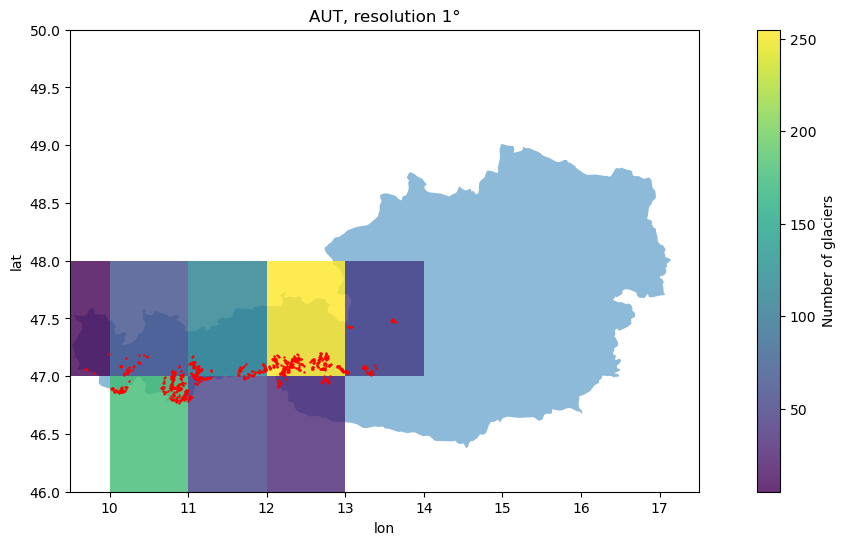

In [15]:
if is_notebook:
    assign_rgi_ids_to_grid_points(test_ds_local,
                                  test_country[name_col_countries].values.item(),
                                  dict_country_to_rgi_ids,
                                  gdf_rgi_ids)
    plot_local_grid_with_glaciers(gdf_rgi_ids,
                                  test_country, test_ds_local,
                                  title=f'{test_country[name_col_countries].values[0]}, resolution '
                                  f'{test_ds_local[0].resolution}°', outpath=None)

## add files which needed to be opened for aggregation

In [16]:
if is_notebook:
    get_result_batches_of_glaciers(test_ds_local, dict_rgis_to_batch)

    for i, grid_loc in enumerate(test_ds_local):
        print(f'{i}. grid files: {list(grid_loc.result_batches.keys())}')

0. grid files: ['P07/0_500', 'P07/1000_1500', 'P07/500_1000']


Figure for debugging if provide regions where correctly selected
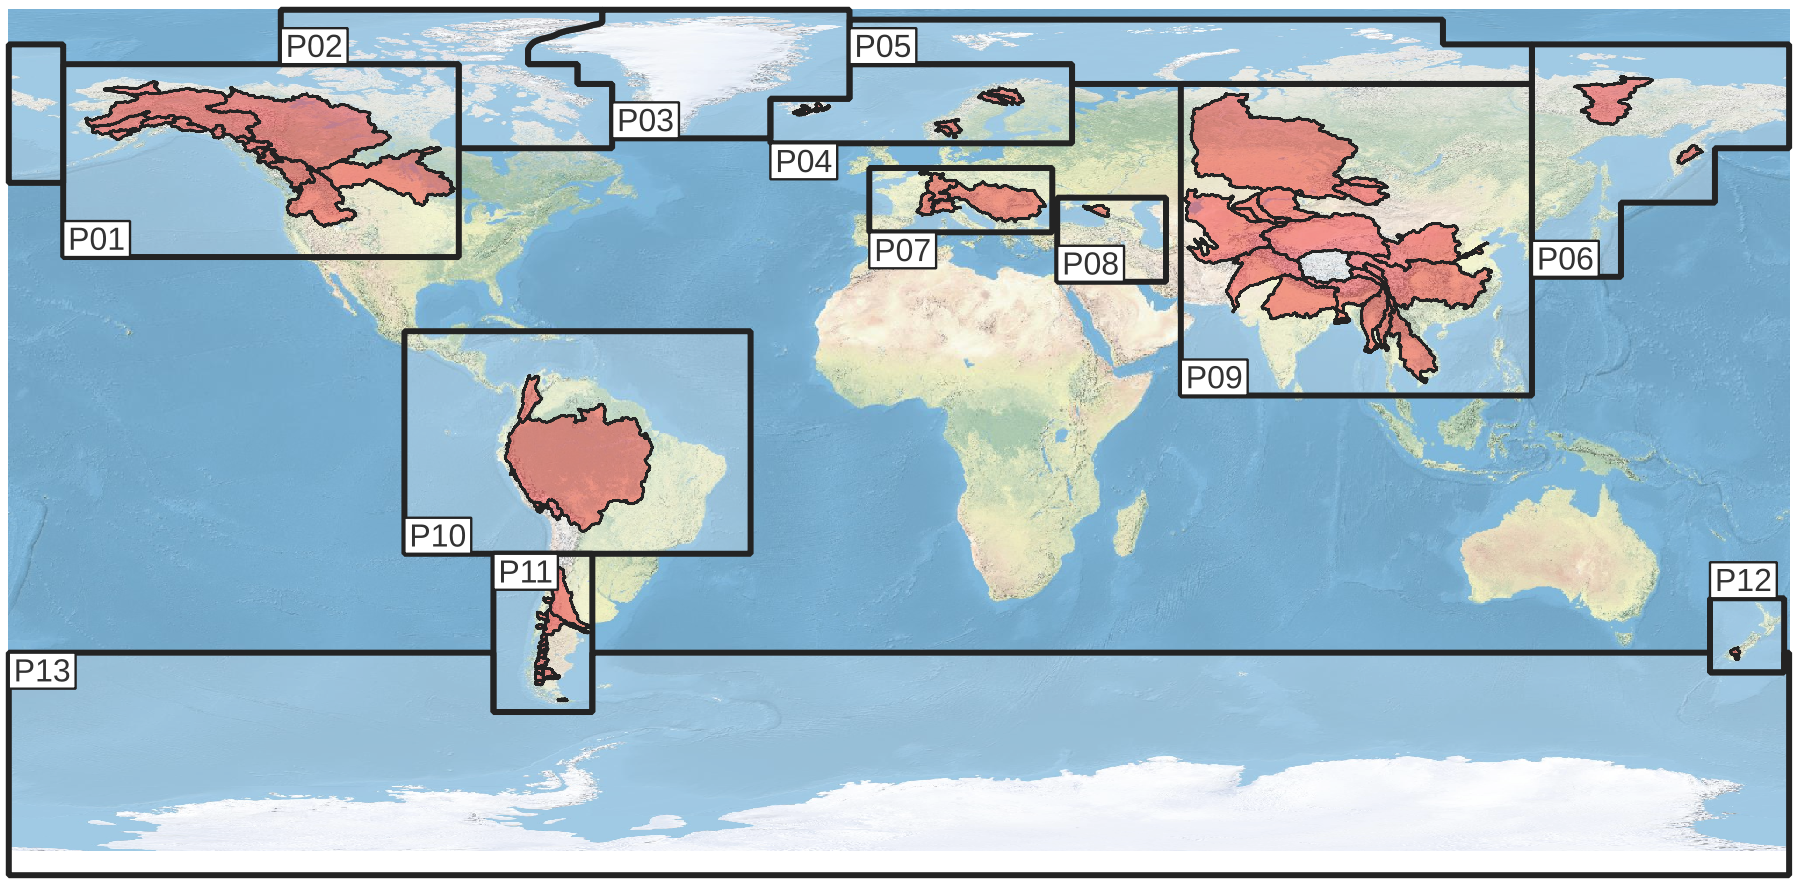

## merge multiple files to one

In [17]:
# can be tested using Russia
if is_notebook:
    if len(test_ds_local) > 1:
        test_ds_local = merge_result_structures(test_ds_local)
    else:
        test_ds_local = test_ds_local[0]

## converting final structure to dictionary for saving and reconverting it to ds again

In [29]:
if is_notebook:
    save_sample_data = False  # for testing the saving
    test_ds_local_dict = serialize_dataset(test_ds_local).to_dict()
    test_key = test_country[name_col_countries].values[0]
    final_dict = {test_key: test_ds_local_dict}

    if save_sample_data:
        with open("prepocessed_country_grids_sample_data.json", "w") as outfile: 
            json.dump(final_dict, outfile)

    # check that we can open the final data
    local_grid_reloaded = open_grid_from_dict(final_dict[test_key])
    print('Original ds:')
    print(test_ds_local)
    print('\nReopened ds:')
    print(local_grid_reloaded)

Original ds:
<xarray.Dataset>
Dimensions:  (lat: 4, lon: 9)
Coordinates:
  * lat      (lat) float64 46.5 47.5 48.5 49.5
  * lon      (lon) float64 9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5
Data variables:
    rgi_ids  (lat, lon) object None ... None
Attributes:
    resolution:             1
    grid_points_with_data:  8
    result_batches:         {'P07/0_500': ['RGI60-11.00476', 'RGI60-11.00490'...

Reopened ds:
<xarray.Dataset>
Dimensions:  (lat: 4, lon: 9)
Coordinates:
  * lat      (lat) float64 46.5 47.5 48.5 49.5
  * lon      (lon) float64 9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5
Data variables:
    rgi_ids  (lat, lon) object None ... None
Attributes:
    resolution:             1
    grid_points_with_data:  8
    result_batches:         {'P07/0_500': ['RGI60-11.00476', 'RGI60-11.00490'...


# Workflow for running on cluster

In [ ]:
# here is the actual code which is running on the cluster for all target shapes
# could use multiprocessing here if it takes too long, but lets see first
# (only takess 10 min for all countries -> multiprocessing not needed)
if not is_notebook:

    start_time = time.time()
    final_dict = {}
    countries_with_no_glaciers = []

    ds_global_grid_resolution = get_global_grid(resolution)

    # loop through all countries and add local grid to final dict
    nr_of_countries = len(gdf_countries)
    for index, row in gdf_countries.iterrows():
        print(f'Starting country number {index + 1} of {nr_of_countries}.')
        country = gpd.GeoDataFrame([row], crs=gdf_countries.crs)

        ds_local_grid = get_squared_grid_for_shape(ds_global_grid_resolution,
                                                   country)

        for grid in ds_local_grid:
            grid.attrs['country'] = country[name_col_countries].values[0]
        assign_rgi_ids_to_grid_points(ds_local_grid,
                                      country[name_col_countries].values.item(),
                                      dict_country_to_rgi_ids,
                                      gdf_rgi_ids)
        if save_local_grid_plots:
            plot_local_grid_with_glaciers(
                gdf_rgi_ids, country, ds_local_grid,
                title=f'{country[name_col_countries].values[0]}, '
                f'{ds_local_grid[0].resolution} °',
                outpath=os.path.join(grid_plots_outpath,
                                     f'{country[name_col_countries].values[0]}.png'))
        get_result_batches_of_glaciers(ds_local_grid, dict_rgis_to_batch)
        if len(ds_local_grid) > 1:
            ds_local_grid = merge_result_structures(ds_local_grid)
        else:
            ds_local_grid = ds_local_grid[0]

        if ds_local_grid.grid_points_with_data == 0:
            # ok this is a country with no glaciers
            countries_with_no_glaciers.append(country[name_col_countries].values[0])
        else:
            # we have some glaciers so let's add
            ds_local_grid_dict = serialize_dataset(ds_local_grid).to_dict()
            final_dict[country[name_col_countries].values[0]] = ds_local_grid_dict

        print(f'Finished country number {index + 1} of {nr_of_countries}.')

    # save final preprocessed file in input dir
    with open(os.path.join(preprocess_country_dict_outpath,
                           "preprocessed_country_grids.json"), "w") as outfile: 
        json.dump(final_dict, outfile)

    # save list of countries with no glaciers
    with open(os.path.join(aggregated_data_outpath,
                           "countries_with_no_glaciers.json"), "w") as outfile: 
        json.dump(countries_with_no_glaciers, outfile)

    print(f'Time needed for {resolution}°: {time.time() - start_time:.1f} s\n\n')